# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [42]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import math
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [56]:
def gini(x):
    IG = 0
    sum_class = 0
    for el in x:
        if el == 0:
            sum_class += 1
    IH = 2 * (sum_class/len(x)) * (1 - (sum_class/len(x)))
    return IH
    
def entropy(x):
    IH = 0
    sum_class = 0
    for el in x:
        if el == 0:
            sum_class += 1
    IH = ((-sum_class) * math.log(sum_class/len(x)))/len(x) - (1 - (sum_class/len(x))) * math.log(1 - (sum_class/len(x)))
    return IH

def gain(left_y, right_y, criterion):
    coeff_node = criterion(left_y + right_y)
    coeff_left = criterion(left_y)
    coeff_right = criterion(right_y)
    return (len(left_y) + len(right_y)) * coeff_node - len(left_y) * coeff_left - len(right_y)*coeff_right

### Задание 2 (2 балла)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [73]:
class DecisionTreeLeaf:
    def __init__(self, prob):
        # вероятность попадания в 0 класс
        self.prob = prob
        if prob > 0.5:
            self.y = 0
        else:
            self.y = 1

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [92]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        if criterion == "gini":
            self.criterion = gini
        else:
            self.criterion = entropy
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    

            
    def tree(self, max_depth, X, y):
        left_y = []
        right_y = []
        split_dim = 0 
        split_value = 0
        col = len(X[0])
        row = len(X)
        max_gain = 0
        for dim in range(col):
            for ind_value in range(row):
                left_y = []
                right_y = []
                for index in range(row):
                    if X[index][dim] < X[ind_value][dim] :
                        left_y.append(y[index])
                    else:
                        right_y.append(y[index])
                if len(left_y) > 0 and len(right_y) > 0:       
                    if gain(left_y, right_y, self.criterion) > max_gain and len(left_y) >= self.min_samples_leaf and len(right_y) >= self.min_samples_leaf:
                        split_dim = dim
                        ind_split_value = ind_value
                        max_gain = gain(left_y, right_y, self.criterion)  
                    
        if max_gain == 0 or max_depth == 1:
            sum_0 = 0
            for i in y:
                if i == 0:
                    sum_0 += 1
            return DecisionTreeLeaf(sum_0/len(y))
        
        left_X = []
        right_X = []
        left_y = []
        right_y = []
        for index in range(row):
            if X[index][split_dim] < X[ind_split_value][split_dim]:
                left_X.append(X[index])
                left_y.append(y[index])
                
            else:
                right_X.append(X[index])
                right_y.append(y[index])
            
        split_value = X[ind_split_value][split_dim]
        return DecisionTreeNode(split_dim, split_value, self.tree(max_depth - 1, left_X, left_y), self.tree(max_depth - 1, right_X, right_y))
        
    
    def fit(self, X, y):
        left_y = []
        right_y = []
        split_dim = 0
        split_value = 0
        col = len(X[0])
        row = len(X)
        max_gain = 0
        for dim in range(col):
            for ind_value in range(row):
                left_y = []
                right_y = []
                for index in range(row):
                    if X[index][dim] < X[ind_value][dim]:
                        left_y.append(y[index])
                    else:
                        right_y.append(y[index])
                if len(left_y) > 0 and len(right_y) > 0:
                    if gain(left_y, right_y, self.criterion) > max_gain and len(left_y) >= self.min_samples_leaf and len(right_y) >= self.min_samples_leaf:
                        split_dim = dim
                        ind_split_value = ind_value
                        max_gain = gain(left_y, right_y, self.criterion)  
        left_X = []
        right_X = []
        left_y = []
        right_y = []
        for index in range(row):
            if X[index][split_dim] < X[ind_split_value][split_dim]:
                left_X.append(X[index])
                left_y.append(y[index])
                
            else:
                right_X.append(X[index])
                right_y.append(y[index])
        split_value = X[ind_split_value][split_dim]
        self.root = DecisionTreeNode(split_dim, split_value, self.tree(self.max_depth - 1, left_X, left_y), self.tree(self.max_depth - 1, right_X, right_y))
        
    
    def predict_proba(self, X):
        y = []
        for x in X:
            node = self.root
            if type(node.left) == DecisionTreeLeaf:
                node_status = 'leaf'
            else:
                node_status = 'node'
            while node_status == 'node':
                if x[node.split_dim] < node.split_value:
                    if type(node.left) == DecisionTreeLeaf:
                        node_status = 'leaf'
                    node = node.left
                else:
                    if type(node.right) == DecisionTreeLeaf:
                        node_status = 'leaf'
                    node = node.right
            y.append({0: node.prob, 1: (1 - node.prob)})
        return y
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [93]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [47]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Протестируйте решение на данных cancer и spam.

In [48]:
data = pandas.read_csv('cancer.csv')
data = data.to_numpy()
row = len(data)
X = [0]*row
y = [0]*row
for i in range(row):
    X[i] = data[i][1:]
    if data[i][0] == 'M':
        y[i] = 1
    else:
        y[i] = 0

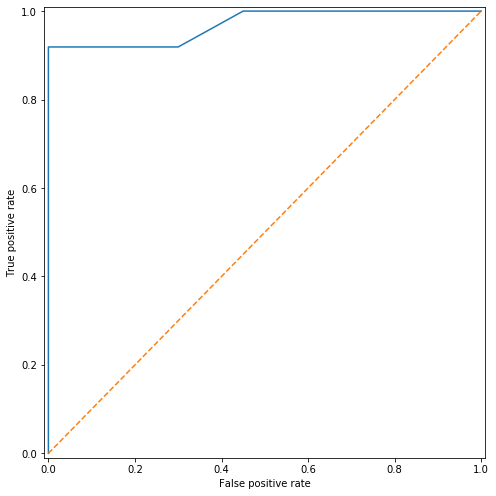

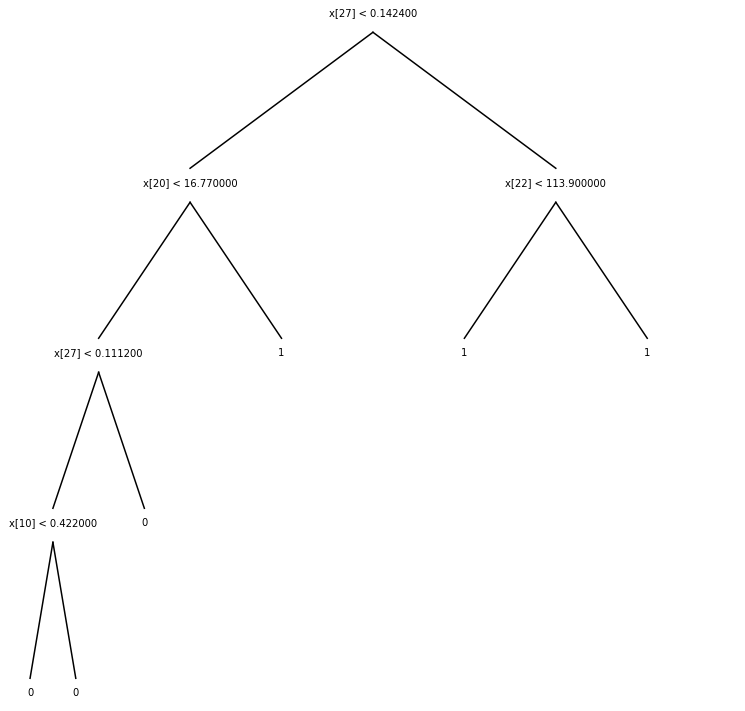

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [94]:
data = pandas.read_csv('spam.csv')
data = data.to_numpy()
row = len(data)
X = [0]*row
y = [0]*row
for i in range(row):
    X[i] = data[i][:-1]
    y[i] = int(data[i][-1])

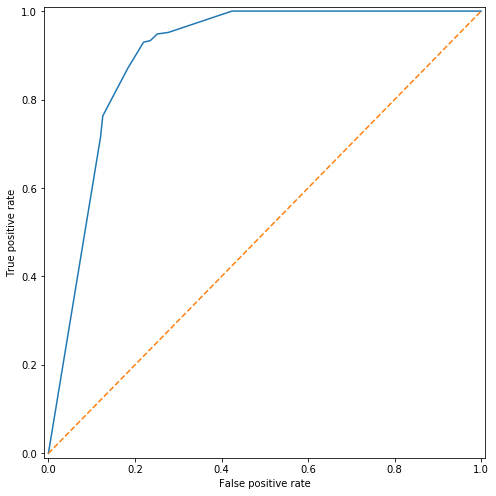

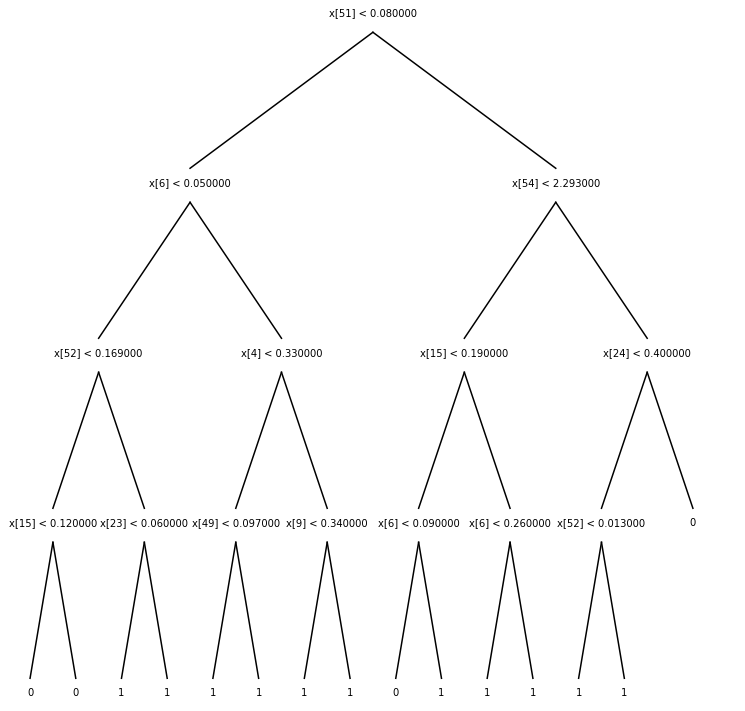

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)